In [2]:
import pickle
import dgl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
os.environ['DGLBACKEND'] = 'pytorch'
from dgl import DGLGraph
import numpy as np
import scipy.sparse as spp
from scipy import spatial
from dgl.data import DGLDataset
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
from ApolloScape_Dataset import ApolloScape_DGLDataset


In [12]:
class ApolloScape_DGLDataset(torch.utils.data.Dataset):
    _raw_dir = '/home/sandra/PROGRAMAS/DBU_Graph/data/apollo_train_data.pkl'
    '''
    def __init__(self,
                 url=None,
                 raw_dir=None,
                 save_dir=None,
                 force_reload=False,
                 verbose=False):
        super(ApolloScape_DGLDataset, self).__init__(name='apolloscape',
                                        url=url,
                                        raw_dir=self._raw_dir,
                                        save_dir=save_dir,
                                        force_reload=force_reload,
                                        verbose=verbose)
    '''
    def __init__(self, data_path=None, train_val='train'):
        self.raw_dir='/home/sandra/PROGRAMAS/DBU_Graph/data/apollo_train_data.pkl'
        self.train_val=train_val
        self.process()        

    def load_data(self):
        with open(self.raw_dir, 'rb') as reader:
            # Training (N, C, T, V)=(5010, 11, 12, 120), (5010, 120, 120), (5010, 2)
            [all_feature, self.all_adjacency, self.all_mean_xy]= pickle.load(reader)
        all_feature=np.transpose(all_feature, (0,3,2,1)) #(N,V,T,C)
        self.all_feature=torch.from_numpy(all_feature[:,:70,:,:]).type(torch.float32)


    def process(self):
        #process data to graph, labels, and splitting masks

        self.load_data()
        total_num = len(self.all_feature)
        '''
        last_vis_obj=[]   #contains number of visible objects in each sequence of the training, i.e. objects in frame 5
        #para hacer grafos de tamaño variable
        for idx in range(len(adj)): 
            for i in range(len(adj[idx])): 
                if adj[idx][i,i] == 0:
                    last_vis_obj.append(i)
                    break   
        '''
        feature_id = [3, 4, 9, 10]  #x,y,heading,[visible_mask]
        now_history_frame=6
        object_type = self.all_feature[:,:,:,2].int()  # torch Tensor NxVxT
        mask_car=np.zeros((total_num,self.all_feature.shape[1],now_history_frame)) #NxVx6
        for i in range(total_num):
            mask_car_t=np.array([1  if (j==2 or j==1) else 0 for j in object_type[i,:,5]])
            mask_car[i,:]=np.array(mask_car_t).reshape(mask_car.shape[1],1)+np.zeros(6) #120x6
        
        self.node_features = self.all_feature[:,:,:now_history_frame,feature_id]  #obj type,x,y 6 primeros frames
        self.node_labels=self.all_feature[:,:,now_history_frame:,3:5] #x,y 6 ultimos frames
        self.node_features[:,:,:,-1] *= mask_car   #Pongo 0 en feat 11 [mask] a todos los obj visibles no-car
        self.node_labels[:,:,:,-1] *= mask_car
        self.output_mask= self.all_feature[:,:,6:,-1]*mask_car #mascara obj (car) visibles en 6º frame (5010,120,6,1)
        self.output_mask = np.array(self.output_mask.unsqueeze_(-1) )

        #EDGES weights  #5010x120x120[]
        self.xy_dist=[spatial.distance.cdist(self.node_features[i][:,5,:], self.node_features[i][:,5,:]) for i in range(len(self.all_feature))]  #5010x120x120

        # TRAIN VAL SETS
        # Remove empty rows from output mask 
        zero_indeces_list = [i for i in range(len(self.output_mask)) if np.all(np.array(self.output_mask.squeeze(-1))==0, axis=(1,2))[i] == True ]

        id_list = list(set(list(range(total_num))) - set(zero_indeces_list))
        total_valid_num = len(id_list)
        ind=np.random.permutation(id_list)
        train_id_list, val_id_list = id_list[:round(total_valid_num*0.8)], id_list[round(total_valid_num*0.8):]

        #train_id_list = list(np.linspace(0, total_num-1, int(total_num*0.8)).astype(int))
        #val_id_list = list(set(list(range(total_num))) - set(train_id_list))  

        if self.train_val.lower() == 'train':
            self.node_features = self.node_features[train_id_list]
            self.node_labels = self.node_labels[train_id_list]
            self.all_adjacency = self.all_adjacency[train_id_list]
            self.output_mask = self.output_mask[train_id_list]
            self.all_mean_xy = self.all_mean_xy[train_id_list]
        elif self.train_val.lower() == 'val':
            self.node_features = self.node_features[val_id_list]
            self.node_labels = self.node_labels[val_id_list]
            self.all_adjacency = self.all_adjacency[val_id_list]
            self.output_mask = self.output_mask[val_id_list]
            self.all_mean_xy = self.all_mean_xy[val_id_list]

    def __len__(self):
        return len(self.node_features)

    def __getitem__(self, idx):
        graph = dgl.from_scipy(spp.coo_matrix(self.all_adjacency[idx][:70,:70])).int()
        graph = dgl.remove_self_loop(graph)
        graph = dgl.add_self_loop(graph)
        distances = [self.xy_dist[idx][graph.edges()[0][i]][graph.edges()[1][i]] for i in range(graph.num_edges())]
        norm_distances = [(i-min(distances))/(max(distances)-min(distances)) if (max(distances)-min(distances))!=0 else (i-min(distances))/1.0 for i in distances]
        norm_distances = [1/(i) if i!=0 else 1 for i in distances]
        graph.edata['w']=torch.tensor(norm_distances, dtype=torch.float32)
        graph.ndata['x']=self.node_features[idx] #obj type, x, y
        graph.ndata['gt']=self.node_labels[idx]
        output_mask = self.output_mask[idx]
        
        return graph, output_mask

In [3]:
train_dataset = ApolloScape_DGLDataset('train')
val_dataset = ApolloScape_DGLDataset('val')

In [15]:
train_dataloader=DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=collate)
val_dataloader=DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate)


In [22]:
with open('../DBU_Graph/data/apollo_train_data.pkl', 'rb') as reader:
    [feat,adj, mean]=pickle.load(reader)
    
feat=np.transpose(feat, (0,3,2,1))
print(adj.shape)

(5010, 120, 120)


In [23]:
features=torch.from_numpy(feat[:,:70,:,:]).type(torch.float32)
print(features.shape)


torch.Size([5010, 70, 12, 11])


In [10]:
'''
#pruebas def preprocess_data de main.py (GRIP) 
feature_id = [3, 4, 9, 10]  #x,y,heading,[visible_mask]
vel_data = feat[:,feature_id]  # N,C,T,V
vel_mask = (vel_data[:, :2, 1:]!=0) * (vel_data[:, :2, :-1]!=0) #False-> frames en los que no tenemos VELOCIDAD del obj
vel_data[:, :2, 1:] = (vel_data[:, :2, 1:] - vel_data[:, :2, :-1]).astype(float) * vel_mask.astype(float)
vel_data[:, :2, 0] = 0
print(vel_data[0,:,6:,0])
#print(new_mask[0,:,:,0])
'''


[[ 1.  1. -0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 6.  7.  8.  9. 10. 11.]
 [ 6.  7.  8.  9. 10.  0.]]


In [6]:
'''
last_vis_obj=[]   #contains number of visible obj in each sequence of the training

for idx in range(len(adj)): 
    for i in range(len(adj[idx])): 
        if adj[idx][i,i] == 0:
            last_vis_obj.append(i)
            break   
            
last_vis_obj
'''

'\nlast_vis_obj=[]   #contains number of visible obj in each sequence of the training\n\nfor idx in range(len(adj)): \n    for i in range(len(adj[idx])): \n        if adj[idx][i,i] == 0:\n            last_vis_obj.append(i)\n            break   \n            \nlast_vis_obj\n'

Graph(num_nodes=120, num_edges=39,
      ndata_schemes={}
      edata_schemes={})


<IPython.core.display.Javascript object>


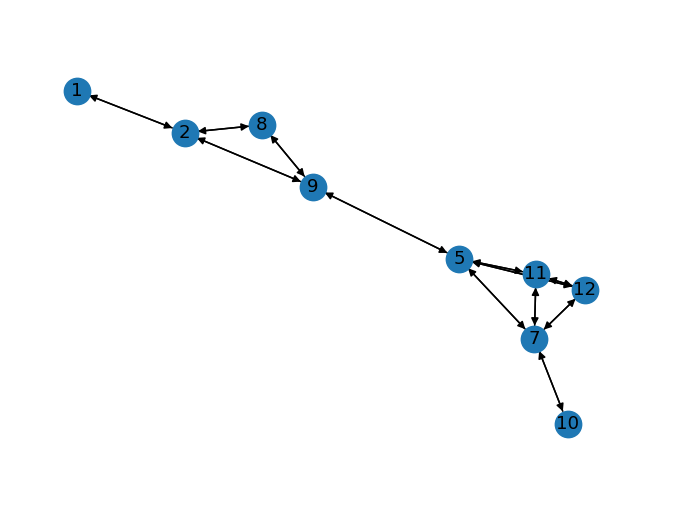

In [193]:
%matplotlib notebook
graph=dgl.DGLGraph(spp.coo_matrix(adj[0]))
print(graph)
nx.draw(graph.to_networkx(), with_labels=True)
plt.show()

<IPython.core.display.Javascript object>


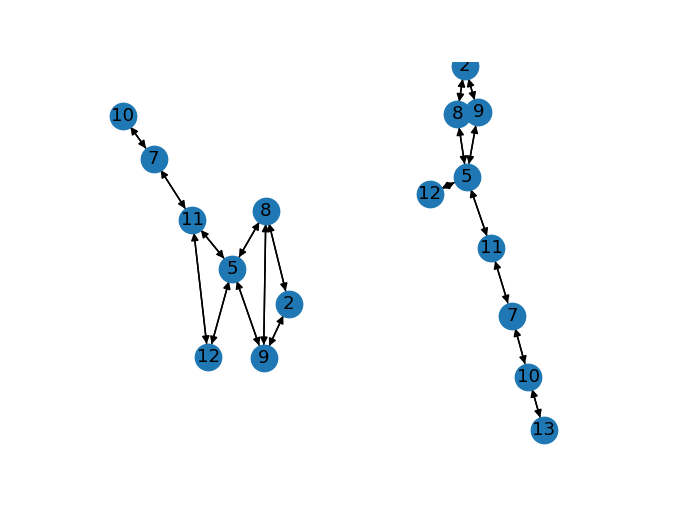

In [11]:
%matplotlib notebook

plt.subplot(1,2,1)
graph=dgl.DGLGraph(spp.coo_matrix(adj[1]))
nx.draw(graph.to_networkx(), with_labels=True)
plt.subplot(1,2,2)
graph=dgl.DGLGraph(spp.coo_matrix(adj[2]))
nx.draw(graph.to_networkx(), with_labels=True)
plt.show()

### PREPROCESS DATA

### Crear grafo (Ejemplo secuencia 0)
Para el entrenamiento iterar sobre todas las secuencias

In [24]:
now_history_frame=6
object_type = features[:,:,:,2].int()  # torch Tensor NxVxT
#vis_obj_type=np.zeros((features.shape[0],features.shape[1])) #NxV
mask_car=np.zeros((features.shape[0],features.shape[1],now_history_frame)) #NxVx6
for i in range(len(features)):
    #vis_obj_type[i,:] =object_type[i,:,5] #Append Vx1 #tipos de obj visibles de la primera seq    
    mask_car_t=np.array([1  if (j==2 or j==1) else 0 for j in object_type[i,:,5]])  #1 si obj 1/2 en frame 5 (size V)
    mask_car[i,:]=np.array(mask_car_t).reshape(mask_car.shape[1],1)+np.zeros(6) #Vx6 mask para los 6 output frames que indican si el obj es visible y car

#COMPROBADO OK

In [25]:

feature_id = [3, 4, 9, 10]  #x,y,heading,[visible_mask]
#120 agentes (13 visibles -> feat[11]=1) y 12 frames (si no hay info en alguno de os 12 frames: fila nula)
node_features = features[:,:,:now_history_frame,feature_id]  #obj type,x,y 6 primeros frames
node_labels=features[:,:,now_history_frame:,3:5] #x,y 6 ultimos frames
node_features[:,:,:,-1] *= mask_car   #Pongo 0 en feat 11 [mask] a todos los obj visibles no-car
node_labels[:,:,:,-1] *= mask_car
output_mask= features[:,:,6:,-1]*mask_car #mascara obj (car) visibles en 6º frame (5010,120,6)
output_mask.unsqueeze_(-1).type(torch.uint8)    #N,V,T,1                  

print(node_features.shape, node_labels.shape,output_mask.shape)

torch.Size([5010, 70, 6, 4]) torch.Size([5010, 70, 6, 2]) torch.Size([5010, 70, 6, 1])


In [26]:
zero_indeces_list = [i for i in range(len(output_mask)) if np.all(np.array(output_mask.squeeze(-1))==0, axis=(1,2))[i] == True ]
zero_indeces_list

[51,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 288,
 289,
 290,
 298,
 299,
 300,
 301,
 311,
 312,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 363,
 364,
 365,
 366,
 1104,
 1105,
 1106,
 1107,
 1108,
 1109,
 1110,
 1111,
 1112,
 1113,
 1114,
 1115,
 1116,
 1117,
 1118,
 1119,
 1191,
 1192,
 1193,
 1194,
 1195,
 1196,
 1197,
 1198,
 1199,
 1200,
 1201,
 1202,
 1203,
 1204,
 1205,
 1206,
 1207,
 1208,
 1209,
 1210,
 1211,
 1212,
 1213,
 1214,
 1215,
 1216,
 1217,
 1218,
 1219,
 1220,
 1221,
 1222,
 1223,
 1224,
 1225,
 1226,
 1227,
 1231,
 1232,
 1233,
 1244,
 1245,
 1246,
 1247,
 1248,
 1249,
 1270,
 1

In [27]:
zero_maskcar_list = [i for i in range(len(mask_car)) if np.all(np.array(mask_car)==0, axis=(1,2))[i] == True ]
len(zero_maskcar_list) #374

374

In [28]:
total_num = len(features)
id_list = list(set(list(range(total_num))) - set(zero_indeces_list))
total_valid_num = len(id_list) #4596
ind=np.random.permutation(id_list)
train_id_list, val_id_list = ind[:round(total_valid_num*0.8)], ind[round(total_valid_num*0.8):]


'''
train_id_list = list(np.linspace(0, total_valid_num-1, int(total_valid_num*0.8)).astype(int))
val_id_list = list(set(list(range(total_valid_num))) - set(train_id_list))  

if train_val_test.lower() == 'train':
    self.all_feature = self.all_feature[train_id_list]
    self.all_adjacency = self.all_adjacency[train_id_list]
    self.all_mean_xy = self.all_mean_xy[train_id_list]
elif train_val_test.lower() == 'val':
    self.all_feature = self.all_feature[val_id_list]
    self.all_adjacency = self.all_adjacency[val_id_list]
    self.all_mean_xy = self.all_mean_xy[val_id_list]
'''
print(len(train_id_list)) #3677

3677


In [29]:
xy_dist=[spatial.distance.cdist(node_features[i][:,5,:], node_features[i][:,5,:]) for i in range(len(features))]  #5010x120x120

In [11]:
####PESOS EN EDGES
#120x120 -> solo quiero los que tengan 1 en Adj[0] (máscara) aka 39 valores
#Obtener las 39 distancias correspondientes a cada edge
distances = [xy_dist[0][graph.edges()[0][i]][graph.edges()[1][i]] for i in range(graph.num_edges())]
print(len(distances))
norm_distances = [(i-min(distances))/(max(distances)-min(distances)) for i in distances]
norm_distances = [1/(i) if i!=0 else 1 for i in distances]
print(norm_distances)
#NORMALIZAR ENTRE 0 Y 1
graph.edata['w']=torch.tensor(norm_distances, dtype=torch.float32)

NameError: name 'graph' is not defined

### Convolutional Layer 

In [30]:
import dgl.function as fn
#Perform message passing and then apply fc Layer (self-loops! - same W for neighbors and itself)
# Traditional GCN:
#fn.copy_src(src='h', out='m')
#gcn_reduce = fn.sum(msg='m', out='h')
# multiply source node features with edge weights and aggregate them in destination nodes
gcn_msg=fn.u_mul_e('h', 'w', 'm') #elemnt-wise (broadcast)
gcn_reduce = fn.sum(msg='m', out='h')
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear_self = nn.Linear(in_feats, in_feats, bias=False)
        self.linear = nn.Linear(in_feats, out_feats)
        
    def reduce_func(self, nodes):
        h = torch.sum(nodes.mailbox['m'], dim=1)
        return {'h': h}

    def forward(self, g, feature,e_w):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.edata['w'] = e_w
            g.ndata['h'] = feature
            g.ndata['h_s']=self.linear_self(feature)
            g.update_all(gcn_msg, self.reduce_func)
            h = g.ndata['h_s'] + self.linear(g.ndata['h'])
            return h

In [16]:
#Prueba forward pass en gcn con un grafo OK
#model = GCN(in_feats=4, hid_feats=64, out_feats=2)
#model(graph, graph.ndata['x'],graph.edata['w'])

In [29]:
from dgl.nn import GatedGraphConv, GraphConv, GATConv,SAGEConv

conv = GraphConv(4,2, weight=True, bias=True)
#sageconv = SAGEConv(4,2,aggregator_type='lstm')
#gated_conv = GatedGraphConv(4, 2, 2, 3)
#gatconv=GATConv(4,2,num_heads=4)
graph = dgl.add_self_loop(graph)   #Añado selfloops pq no puede haber zero in-degree nodes
res = conv(graph, node_features[0])
print(res.shape)

torch.Size([70, 6, 2])


### Graph Convolutional Model

In [10]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = GCNLayer(in_feats=in_feats, out_feats=hid_feats)
        self.conv2 = GCNLayer(in_feats=hid_feats, out_feats=out_feats)
        self.fc= nn.Linear(out_feats,out_feats)
    def forward(self, graph, inputs,e_w):
        #inputs are features of nodes
        h = self.conv1(graph, inputs,e_w)
        h = F.relu(h)
        h = self.conv2(graph,h,e_w)  #120x6x2  (VxTxC)
        y = self.fc(h)
        return y
        

### GAT Layer

In [30]:
class My_GATLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GATLayer, self).__init__()
        self.linear_self = nn.Linear(in_feats, out_feats, bias=False)
        self.linear_func = nn.Linear(in_feats, out_feats, bias=False)
        self.attention_func = nn.Linear(2 * out_feats, 1, bias=False)
        
    def edge_attention(self, edges):
        concat_z = torch.cat([edges.src['z'], edges.dst['z']], dim=1).sum(dim=0) #(6,2)||(6,2) -> (6,4) -> (4)
        src_e = self.attention_func(concat_z)  #(1) att logit
        src_e = F.leaky_relu(src_e)
        return {'e': src_e}
    
    def message_func(self, edges):
        return {'z': edges.src['z'], 'e':edges.data['e']}
        
    def reduce_func(self, nodes):
        h_s = nodes.data['h_s']
        a = F.softmax(nodes.mailbox['e'], dim=1)   #attention score between nodes i and j
        h = h_s + torch.sum(a * nodes.mailbox['z'], dim=1)
        return {'h': h}
                               
    def forward(self, graph, h):
        h_in = h
        g.ndata['h']  = h 
        g.ndata['h_s'] = self.linear_self(h) 
        g.ndata['z'] = self.linear_func(h) #(6,4) -> (6,2) infeats=4 outfeats=2
        graph.apply_edges(self.edge_attention)
        graph.update_all(self.message_func, self.reduce_func)
        h = g.ndata['h'] # result of graph convolution
        #h = h * snorm_n # normalize activation w.r.t. graph node size
        #h = self.bn_node_h(h) # batch normalization 
        h = torch.relu(h) # non-linear activation
        h = h_in + h # residual connection
        return h #graph.ndata.pop('h')


class MultiHeadGATLayer(nn.Module):
    def __init__(self, in_feats, out_feats, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(My_GATLayer(in_dim, out_dim))
        self.merge = merge

    def forward(self, g, h):
        head_outs = [attn_head(g, h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1), for intermediate layers
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average, for final layer
            return torch.mean(torch.stack(head_outs))

In [ ]:
class MLP_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, input_dim) 
        self.layer2 = nn.Linear(input_dim, output_dim) 
        
    def forward(self, x):
        y = x
        y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y

In [ ]:
class My_GAT(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super().__init__()
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.gat_1 = GATLayer(hidden_dim, hidden_dim)
        self.gat_2 = GATLayer(hidden_dim, hidden_dim)
        #self.gat_1 = MultiHeadGATLayer(hidden_dim, hidden_dim, heads)
        #self.gat_2 = MultiHeadGATLayer(hidden_dim*heads, hidden_dim, 1)
        self.linear1 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, g, h):
        
        # input embedding
        h = self.embedding_h(h)  #input (6,4) - (6,32)
        
        # gat layers
        h = F.relu(self.gat_1(g, h))
        h = F.relu(self.gat_2(g, h))
        
        y = self.linear1(h)  # (6,32) -> (6,2)
        
        return y

### TRAINING Tests

#### Collate function to prepare graphs

In [20]:
def compute_RMSE(pred, gt, mask): 
    #output mask vale 0 si no visible o no-car o visible pero no hay datos en ese frame  (70,6,1)
    pred = pred*mask #Con esto ya quito del error aquellas filas donde no tengo datos.
    gt = gt*mask  #120 nodos outputmask V,T,C
    x2y2_error=torch.sum(torch.abs(pred-gt)**2,dim=2) #V,T 
    overall_sum_time = x2y2_error.sum(dim=0).requires_grad_()  #T - suma de los errores de los V agentes
    overall_num = mask.sum(dim=-1).sum(dim=0).type(torch.int) #torch.Tensor[(T)] - num de agentes en cada frame
    return overall_sum_time, overall_num, x2y2_error



In [5]:
def compute_RMSE_batch(pred, gt, mask): 
    #output mask vale 0 si no visible o no-car o visible pero no hay datos en ese frame  B,V,T,1
    pred = pred*mask #B,V,T,C  (B n grafos en el batch)
    gt = gt*mask  # outputmask B,V,T,C
    x2y2_error=torch.sum(torch.abs(pred-gt)**2,dim=-1) #B,V,T 
    overall_sum_time = x2y2_error.sum(dim=-2).requires_grad_()  #B,T - suma de los errores de los V agentes
    overall_num = mask.sum(dim=-1).sum(dim=-2).type(torch.int) #torch.Tensor[(T)] - num de agentes en cada frame
    return overall_sum_time, overall_num, x2y2_error



In [31]:
dev = 'cuda'
model = GCN(in_feats=4, hid_feats=64, out_feats=2).to(dev)
#model = My_GAT(input_dim=4, hidden_dim=64, output_dim=2)

opt = torch.optim.Adam(model.parameters(), lr=0.001)
def err_handler(type, flag):
    print("Floating point error (%s), with flag %s,iter %d" % (type, flag, i))
np.seterrcall(err_handler)
np.seterr(all='raise')
for epoch in range(20):
    print('Epoch: ',epoch)
    overall_loss_train=[]
    overall_loss_val=[]
    model.train()
    for i in train_id_list:
        graph = dgl.from_scipy(spp.coo_matrix(adj[i][:70,:70])).int()
        graph = dgl.remove_self_loop(graph)
        graph = dgl.add_self_loop(graph).to(dev)
        #graph.ndata['x']=node_features[i] # x, y, heading,mask
        #graph.ndata['gt']=node_labels[i] #x,y
        distances = [xy_dist[i][graph.edges()[0][i]][graph.edges()[1][i]] for i in range(graph.num_edges())]
        norm_distances = [(i-min(distances))/(max(distances)-min(distances)) if (max(distances)-min(distances))!=0 else (i-min(distances))/1.0 for i in distances]
        norm_distances = [1/(i) if i!=0 else 1 for i in distances]
        e_w=torch.tensor(norm_distances, dtype=torch.float32).to(dev)
        
        #forward prop by using all nodes
        pred = model(graph, node_features[i].to(dev),e_w)  #pred 120x6x2 , output mask 120x6x1
        #compute loss
        overall_sum_time, overall_num, _ = compute_RMSE(pred, node_labels[i].to(dev), output_mask[i].to(dev))
        if torch.sum(overall_num) == 0:
            print(i)
        total_loss=torch.sum(overall_sum_time)/torch.sum(overall_num)#torch.max(torch.sum(overall_num).type(torch.int), torch.ones(1,).type(torch.int).to(dev))    
        opt.zero_grad() 
        total_loss.backward()
        opt.step()
        overall_loss_train.extend([total_loss.detach().cpu().numpy().sum(axis=0)])
    #print('|{}| Train_loss: {}'.format(datetime.now(), ' '.join(['{:.3f}'.format(x) for x in list(overall_loss_train) + [np.sum(overall_loss_train)]])))
    print('|{}| Train_loss: {}'.format(datetime.now(), np.sum(overall_loss_train)))

    model.eval()
    with torch.no_grad():
        for i in val_id_list:
            graph = dgl.from_scipy(spp.coo_matrix(adj[i][:70,:70])).int()
            graph = dgl.remove_self_loop(graph)
            graph = dgl.add_self_loop(graph).to(dev)
            distances = [xy_dist[i][graph.edges()[0][i]][graph.edges()[1][i]] for i in range(graph.num_edges())]
            norm_distances = [(i-min(distances))/(max(distances)-min(distances)) if (max(distances)-min(distances))!=0 else (i-min(distances))/1.0 for i in distances]
            norm_distances = [1/(i) if i!=0 else 1 for i in distances]
            e_w=torch.tensor(norm_distances, dtype=torch.float32).to(dev)
            
            #forward prop by using all nodes
            pred = model(graph, node_features[i].to(dev),e_w)
            _, overall_num, x2y2_error = compute_RMSE(pred, node_labels[i].to(dev), output_mask[i].to(dev))
            x2y2_error=x2y2_error.detach().cpu().numpy().sum(axis=0)
            overall_sum_time = np.sum(x2y2_error**0.5, axis=0)  #suma del error de todos los agentes en los T frames
            overall_num_time = np.sum(overall_num.detach().cpu().numpy(), axis=0) #numero de agentes en los T frames
            overall_loss_val.extend([overall_sum_time / (overall_num_time)]) #media del error de cada agente en los T frames
            
    print('|{}| Val_loss: {}'.format(datetime.now(), ' '.join(['{:.3f}'.format(x) for x in list(overall_loss_val) + [np.sum(overall_loss_val)]])))


Epoch:  0
|2020-11-06 17:26:21.675820| Train_loss: 3093478.4822861166
|2020-11-06 17:26:43.801498| Val_loss: 13.980 6.942 10.648 9.213 5.242 1.596 6.459 17.933 4.638 1.893 18.578 13.486 9.841 20.404 6.695 16.196 17.306 24.211 9.383 10.218 15.659 7.235 8.152 10.214 4.641 26.500 2.596 6.029 19.246 16.360 7.438 22.755 17.703 11.656 5.708 1.798 11.712 7.013 13.701 2.496 3.708 8.033 8.849 2.471 7.967 18.353 12.227 1.514 1.547 6.083 9.974 9.202 22.467 9.819 7.776 29.074 5.480 4.760 5.448 4.448 8.043 8.850 12.543 14.349 10.513 14.620 5.096 20.398 12.796 26.647 8.695 11.402 13.845 12.831 6.943 9.170 7.788 9.808 10.092 6.156 17.752 15.173 10.478 17.471 1.924 7.090 25.530 14.394 39.705 7.673 3.993 17.786 15.707 13.543 7.747 12.432 5.500 21.064 3.605 3.766 14.243 22.617 10.165 31.068 8.970 3.105 10.028 10.377 4.639 14.715 4.680 13.887 10.349 19.665 3.149 8.852 8.710 13.298 5.178 11.273 14.456 17.560 5.890 11.336 7.305 6.812 18.166 5.648 19.007 20.351 12.868 5.399 17.177 7.457 6.986 13.352 10.931 

|2020-11-06 17:30:22.906455| Train_loss: 3703644.0543529773
|2020-11-06 17:30:47.139842| Val_loss: 13.848 6.954 10.666 8.665 5.217 2.215 6.528 17.925 4.667 1.905 18.498 13.565 9.639 20.448 6.700 16.156 17.417 24.374 9.389 10.353 15.653 7.222 8.032 10.265 4.590 26.756 2.619 5.977 19.351 16.296 7.575 22.638 17.665 11.699 5.065 1.735 11.778 6.936 13.706 2.518 3.780 8.046 8.865 2.477 8.043 18.220 12.231 1.574 1.573 6.279 9.922 9.054 22.640 9.801 7.466 29.166 5.449 4.663 5.557 4.513 8.061 8.085 12.451 14.169 9.692 14.756 5.212 20.180 12.720 26.295 8.694 11.334 13.861 12.561 7.230 9.148 8.109 9.572 10.075 6.107 17.853 14.905 10.418 17.523 1.930 6.872 26.138 14.686 41.202 7.735 3.971 17.724 15.623 13.386 7.796 12.435 5.582 21.254 3.547 3.662 14.169 22.428 10.108 31.339 8.891 3.135 10.005 10.323 4.611 14.795 4.668 14.422 10.245 19.695 3.012 8.889 8.811 13.245 5.126 11.218 14.314 17.605 5.894 11.384 7.238 6.989 18.282 5.717 19.115 20.506 12.679 5.391 17.110 7.450 6.976 13.261 10.899 14.366 7.03

|2020-11-06 17:34:42.590081| Train_loss: 2608194.9132525995
|2020-11-06 17:35:05.752108| Val_loss: 13.763 6.894 10.723 8.221 5.232 3.033 6.751 17.959 4.656 1.906 18.256 13.629 9.333 20.590 6.728 16.176 17.762 24.834 9.368 10.516 15.643 7.185 8.072 10.326 4.573 28.672 2.723 6.006 19.447 16.339 7.537 22.582 17.466 11.797 4.851 1.808 11.775 6.914 13.710 2.592 3.780 8.024 8.816 2.398 7.994 18.135 12.409 1.976 1.591 6.628 9.478 9.170 22.678 9.883 7.462 29.281 5.473 4.642 5.655 4.367 8.068 7.249 12.244 13.978 10.534 14.800 5.269 20.194 12.581 26.227 8.612 11.301 13.862 12.480 7.183 9.071 8.429 8.327 10.061 6.189 17.969 14.673 10.254 17.636 1.872 6.713 26.550 14.767 41.212 7.781 4.015 17.615 15.633 13.061 7.876 12.536 5.648 21.815 3.494 3.601 14.058 21.969 9.963 31.174 8.771 3.176 9.947 10.302 4.652 15.010 4.680 14.663 10.215 19.704 2.910 8.817 8.789 13.347 5.043 11.245 14.353 17.705 5.899 11.769 7.285 6.874 18.377 5.849 19.207 20.634 12.553 5.365 16.934 7.409 6.966 13.101 10.412 14.909 7.030

|2020-11-06 17:38:56.841913| Train_loss: 2223289.173170403
|2020-11-06 17:39:20.181527| Val_loss: 13.730 6.843 10.768 7.412 5.219 3.541 6.869 18.012 4.690 1.937 18.103 13.752 9.189 20.837 6.737 16.249 18.096 25.062 9.364 10.638 15.660 7.149 8.116 10.302 4.545 29.813 2.839 6.084 19.591 16.425 7.578 22.528 17.254 11.815 5.404 1.881 11.933 6.866 13.725 2.634 3.814 8.076 8.773 2.412 7.937 18.068 12.535 2.318 1.676 6.915 9.063 9.386 22.470 9.881 7.479 29.468 5.425 4.578 5.752 4.233 8.021 6.338 11.953 13.800 10.827 14.899 5.334 20.253 12.381 26.234 8.649 11.325 13.873 12.633 7.324 8.944 8.479 7.272 10.029 6.251 18.180 14.418 10.068 17.829 1.879 6.488 26.485 14.610 40.492 7.813 4.079 17.541 15.598 12.683 7.824 12.666 5.728 22.124 3.429 3.549 13.913 21.661 9.846 30.999 8.669 3.167 9.854 10.323 4.705 15.134 4.725 14.174 10.294 19.598 2.811 8.647 8.574 13.398 5.014 11.287 14.443 17.868 5.901 12.236 7.343 6.668 18.442 5.968 19.331 20.733 12.383 5.298 16.828 7.363 6.986 12.926 9.927 15.519 6.937 1

|2020-11-06 17:43:16.309112| Train_loss: 2096177.4207743453
|2020-11-06 17:43:39.750266| Val_loss: 13.509 6.741 10.732 7.702 5.204 3.756 6.881 17.752 4.677 1.887 17.686 13.712 9.303 20.917 6.653 16.086 18.049 25.413 9.371 10.720 15.931 6.986 8.220 10.241 4.376 29.124 2.846 6.095 19.928 16.257 7.564 22.126 16.603 11.795 5.809 1.942 12.143 6.725 13.923 2.586 3.874 8.190 8.757 2.458 7.904 17.570 12.354 2.685 1.735 7.056 9.341 9.741 22.185 9.839 7.867 29.775 5.826 4.400 5.729 4.038 8.029 5.530 11.563 13.370 12.792 14.917 5.342 20.284 12.392 26.012 8.593 11.205 14.034 12.579 7.227 9.004 8.287 7.346 9.929 6.365 18.370 13.790 10.109 18.083 1.828 6.330 25.762 14.380 40.423 7.849 3.967 17.303 15.537 12.663 7.851 12.763 5.719 22.257 3.479 3.605 13.531 20.894 9.862 31.504 8.683 3.180 9.620 10.299 4.597 15.197 4.710 12.832 10.294 19.495 2.952 8.467 8.401 13.358 5.056 11.189 14.254 17.972 5.905 12.767 7.446 6.384 18.589 5.930 19.668 21.096 12.478 5.096 15.850 7.339 6.898 12.533 10.149 16.270 6.910 

|2020-11-06 17:47:34.371717| Train_loss: 1974435.4088210156
|2020-11-06 17:47:58.728546| Val_loss: 13.255 6.566 10.621 8.530 5.451 3.394 6.939 17.328 4.803 1.935 16.973 13.702 9.898 21.286 6.514 15.826 17.470 25.433 9.291 11.236 16.617 6.769 8.379 10.080 4.012 29.388 3.046 6.069 20.643 16.007 7.678 20.976 15.849 11.405 6.581 2.064 12.494 6.555 14.368 2.428 3.893 8.384 8.719 2.903 7.988 16.772 11.438 3.253 2.002 6.910 9.961 10.353 21.659 10.002 7.565 31.341 6.582 4.266 5.742 3.894 8.028 4.606 10.737 12.774 12.784 15.009 5.271 20.663 12.422 25.851 8.561 10.959 14.415 12.697 7.200 9.102 7.072 7.933 9.739 6.561 18.867 12.469 10.118 18.422 1.915 6.255 24.043 14.502 39.476 7.999 3.892 16.911 15.297 12.711 8.044 12.998 5.679 22.187 3.603 3.747 12.762 19.527 10.140 32.772 8.777 3.261 9.099 10.066 4.466 15.184 4.710 11.504 10.147 19.399 3.274 7.933 7.739 13.472 5.170 10.500 13.397 18.269 5.823 13.163 7.718 6.085 18.863 5.922 20.363 22.063 12.678 4.737 14.962 7.370 6.922 11.846 10.658 16.753 6.9

|2020-11-06 17:51:51.695069| Train_loss: 1928822.3025193475
|2020-11-06 17:52:14.760452| Val_loss: 13.183 6.495 10.580 8.625 5.471 3.551 6.870 17.029 4.835 1.945 16.814 13.688 10.288 21.380 6.501 15.709 17.254 25.381 9.301 11.344 16.941 6.683 8.306 10.102 3.830 29.356 3.088 6.094 20.822 15.877 7.678 20.517 15.546 11.295 7.082 2.074 12.580 6.529 14.435 2.358 3.906 8.523 8.750 3.007 8.009 16.573 11.155 3.256 2.097 6.867 9.944 10.379 21.331 10.083 7.391 31.746 6.607 4.242 5.744 3.805 7.993 4.954 10.543 12.612 11.218 15.009 5.334 20.695 12.457 25.609 8.486 10.898 14.466 12.782 7.210 9.129 6.076 8.121 9.664 6.600 19.063 12.267 10.151 18.590 1.921 6.198 23.396 14.710 39.543 8.007 3.871 16.806 15.012 12.793 8.135 13.038 5.689 22.042 3.621 3.796 12.447 19.131 10.242 33.706 8.816 3.222 8.914 10.019 4.432 15.003 4.734 9.684 10.119 19.372 3.438 7.813 7.597 13.489 5.166 10.284 12.996 18.328 5.807 13.239 7.711 5.962 18.897 5.914 20.531 22.214 12.711 4.591 14.325 7.362 6.915 11.596 10.642 16.878 6.9

|2020-11-06 17:57:54.256275| Train_loss: 1918882.4334173077
|2020-11-06 17:58:42.153296| Val_loss: 13.289 6.504 10.608 8.259 5.398 4.020 6.844 16.963 4.818 1.945 16.876 13.550 10.290 21.256 6.515 15.719 17.324 25.424 9.365 11.237 16.871 6.656 8.270 10.198 3.861 29.467 3.111 6.101 20.612 15.807 7.693 20.736 15.568 11.353 6.861 2.011 12.646 6.578 14.297 2.387 3.893 8.462 8.815 2.888 7.958 16.795 11.342 3.175 2.071 6.937 9.612 10.197 21.378 9.868 7.327 31.310 6.389 4.252 5.746 3.892 7.980 4.810 10.806 12.712 11.150 15.047 5.529 20.346 12.371 25.259 8.499 11.014 14.335 12.592 7.308 9.015 6.124 7.575 9.647 6.575 18.901 12.476 10.065 18.631 1.883 6.030 23.991 14.356 39.615 7.916 3.853 16.848 15.417 12.656 8.101 12.919 5.701 22.035 3.553 3.763 12.525 19.326 10.140 33.136 8.768 3.167 9.021 10.060 4.426 14.951 4.721 9.259 10.143 19.219 3.415 8.006 7.824 13.428 5.111 10.387 13.274 18.224 5.864 13.255 7.645 6.145 18.802 5.955 20.326 22.093 12.577 4.656 14.179 7.352 6.940 11.687 10.299 16.882 6.86

|2020-11-06 18:03:48.129646| Train_loss: 1887309.9737369562
|2020-11-06 18:04:13.309704| Val_loss: 13.178 6.489 10.589 8.593 5.463 4.229 6.796 16.897 4.870 2.003 16.716 13.583 10.367 21.260 6.498 15.696 17.349 25.222 9.375 11.274 17.003 6.613 8.281 10.209 3.831 29.749 3.187 6.117 20.757 15.736 7.782 20.599 15.347 11.280 6.883 2.065 12.861 6.555 14.358 2.415 3.896 8.548 8.815 2.944 7.982 16.684 11.327 3.239 2.152 7.123 9.322 10.201 21.247 9.801 7.378 31.610 6.529 4.233 5.826 3.823 8.007 4.662 10.731 12.592 10.880 15.184 5.532 20.393 12.275 25.172 8.486 11.003 14.393 12.497 7.415 9.005 6.526 7.062 9.610 6.600 19.024 12.324 10.037 18.731 1.933 5.925 23.590 14.113 39.305 7.952 3.780 16.777 15.451 12.563 8.075 12.962 5.733 21.816 3.517 3.762 12.295 18.971 10.124 32.946 8.730 3.247 8.925 9.992 4.349 14.928 4.721 9.713 10.060 19.030 3.541 7.982 7.793 13.442 5.111 10.280 13.190 18.269 5.882 13.354 7.688 6.081 18.895 6.053 20.476 22.307 12.553 4.591 13.598 7.358 6.990 11.602 9.934 16.986 6.829 

|2020-11-06 18:08:12.813837| Train_loss: 1878917.7254688833
|2020-11-06 18:08:38.779905| Val_loss: 13.083 6.460 10.568 8.870 5.524 4.381 6.740 16.810 4.949 2.044 16.645 13.514 10.423 21.351 6.531 15.715 17.443 25.092 9.391 11.360 17.134 6.589 8.197 10.233 3.769 29.608 3.210 6.130 20.939 15.692 7.832 20.453 15.161 11.297 6.904 2.112 13.025 6.515 14.416 2.431 3.877 8.606 8.819 2.989 7.984 16.544 11.381 3.324 2.211 7.371 9.157 10.201 21.155 9.695 7.366 31.919 6.553 4.219 5.888 3.774 8.033 4.527 10.586 12.462 10.672 15.285 5.574 20.470 12.214 25.009 8.489 10.945 14.450 12.424 7.541 8.980 6.552 6.872 9.584 6.589 19.022 12.283 10.015 18.859 1.953 5.824 23.461 13.940 39.722 7.998 3.772 16.750 15.444 12.525 8.020 13.026 5.774 21.547 3.492 3.760 12.119 18.755 10.123 33.090 8.681 3.291 8.893 9.949 4.328 14.905 4.737 9.459 9.972 18.880 3.561 7.924 7.719 13.419 5.130 10.171 13.028 18.364 5.847 13.367 7.600 6.028 18.993 6.132 20.655 22.375 12.471 4.524 13.099 7.360 7.012 11.473 9.746 17.037 6.824 1

In [6]:
# Collate function to prepare graphs
def collate(samples):
    graphs, masks = map(list, zip(*samples))  # samples is a list of pairs (graph, mask) mask es VxTx1
    masks = torch.tensor(masks)
    sizes_n = [graph.number_of_nodes() for graph in graphs] # graph sizes
    snorm_n = [torch.FloatTensor(size, 1).fill_(1 / size) for size in sizes_n]
    snorm_n = torch.cat(snorm_n).sqrt()  # graph size normalization 
    sizes_e = [graph.number_of_edges() for graph in graphs] # nb of edges
    snorm_e = [torch.FloatTensor(size, 1).fill_(1 / size) for size in sizes_e]
    snorm_e = torch.cat(snorm_e).sqrt()  # graph size normalization
    batched_graph = dgl.batch(graphs)  # batch graphs
    return batched_graph, masks, snorm_n, snorm_e

In [21]:
model = GCN(in_feats=4, hid_feats=64, out_feats=2)
#model = My_GAT(input_dim=4, hidden_dim=64, output_dim=2)

opt = torch.optim.Adam(model.parameters(), lr=0.001)
np.seterr(all='raise')

for epoch in range(20):
    print('Epoch: ',epoch)
    overall_loss_train=[]
    overall_loss_val=[]
    model.train()
        
    for batched_graph, output_masks,snorm_n, snorm_e in train_dataloader:
        feats = batched_graph.ndata['x'].float()
        e_w = batched_graph.edata['w'].float()
        labels= batched_graph.ndata['gt'].float()
        pred = model(batched_graph, feats,e_w)
        overall_sum_time, overall_num, _ = compute_RMSE(pred, labels, output_masks)
        
        total_loss=torch.sum(overall_sum_time)/torch.max(torch.sum(overall_num).type(torch.int),torch.ones(1,).type(torch.int))
        
        opt.zero_grad() 
        total_loss.backward()
        opt.step()
        overall_loss_train.extend([total_loss.detach().cpu().numpy().sum(axis=0)])
    #print('|{}| Train_loss: {}'.format(datetime.now(), ' '.join(['{:.3f}'.format(x) for x in list(overall_loss_train) + [np.sum(overall_loss_train)]])))
    print('|{}| Train_loss: {}'.format(datetime.now(), np.sum(overall_loss_train)))

    model.eval()
    with torch.no_grad():
        for batched_graph, output_masks,snorm_n, snorm_e in val_dataloader:
            feats = batched_graph.ndata['x'].float()
            e_w = batched_graph.edata['w'].float()
            labels= batched_graph.ndata['gt'].float()
            pred = model(batched_graph, feats,e_w)
            _, overall_num, x2y2_error = compute_RMSE(pred, labels, output_masks)
            x2y2_error=x2y2_error.detach().cpu().numpy().sum(axis=0)
            overall_sum_time = np.sum(x2y2_error**0.5, axis=0)  #suma del error de todos los agentes en los T frames
            overall_num_time = np.sum(overall_num.detach().cpu().numpy(), axis=0) #numero de agentes en los T frames
            overall_loss_val.extend([overall_sum_time / overall_num_time]) #media del error de cada agente en los T frames
            
    print('|{}| Val_loss: {}'.format(datetime.now(), ' '.join(['{:.3f}'.format(x) for x in list(overall_loss_val) + [np.sum(overall_loss_val)]])))


Epoch:  0
|2020-11-06 17:23:09.851146| Train_loss: 4354285517071.0347


ValueError: operands could not be broadcast together with shapes (2,) (6,) 

In [107]:
batched_graph, output_masks,snorm_n, snorm_e= next(iter(train_dataloader))
feats = batched_graph.ndata['x'].float()
e_w = batched_graph.edata['w'].float()
labels= batched_graph.ndata['gt'].float()
pred = model(batched_graph, feats,e_w)

In [19]:
x2y2_error.shape

(70, 6)